In [10]:
!pip install -q monai nibabel
!pip install -q torchio


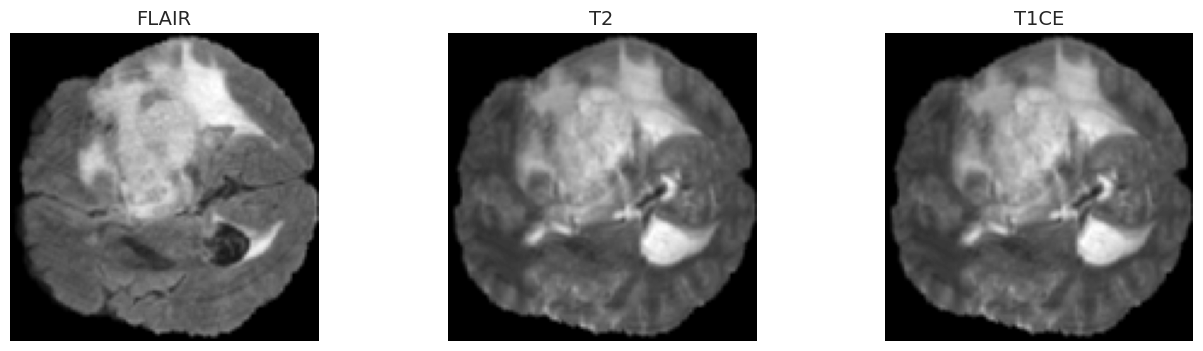

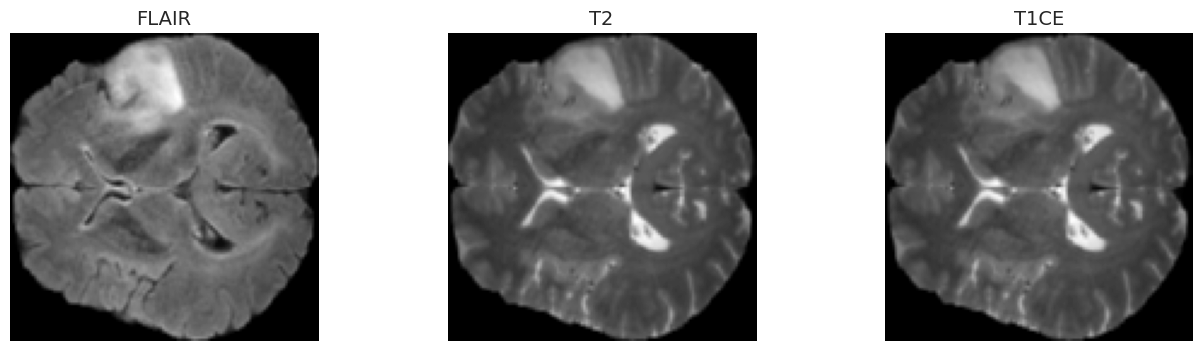

Processed 369 patients successfully


In [11]:
import os
import random
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, Spacingd, ScaleIntensityRanged,
    CropForegroundd, Resized, ToTensord, SpatialCropd
)
from monai.data import Dataset, DataLoader

# مسارات الداتاسيت
data_dir = "/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"
output_dir = "/kaggle/working/processed"
os.makedirs(output_dir, exist_ok=True)

# قايمة الحالات
patient_list = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d)) and not d.endswith(".csv")])

# إنشاء فولدرات لكل مريض
for patient in patient_list:
    os.makedirs(os.path.join(output_dir, patient), exist_ok=True)

# إعداد قايمة البيانات (FLAIR, T2, T1CE)
data_dicts = []
skipped_patients = []
for patient in patient_list:
    flair_path = os.path.join(data_dir, patient, f"{patient}_flair.nii")
    t2_path = os.path.join(data_dir, patient, f"{patient}_t2.nii")
    t1ce_path = os.path.join(data_dir, patient, f"{patient}_t1ce.nii")
    try:
        # فحص وجود الملفات
        if not (os.path.exists(flair_path) and os.path.exists(t2_path) and os.path.exists(t1ce_path)):
            skipped_patients.append((patient, "Missing file(s)"))
            continue
        # فحص تحميل الملفات
        nib.load(flair_path)
        nib.load(t2_path)
        nib.load(t1ce_path)
        data_dicts.append({
            "flair": flair_path,
            "t2": t2_path,
            "t1ce": t1ce_path,
        })
    except Exception as e:
        skipped_patients.append((patient, f"Failed to load files: {str(e)}"))
        continue

# تعريف التحويلات
transforms = Compose([
    LoadImaged(keys=["flair", "t2", "t1ce"]),
    EnsureChannelFirstd(keys=["flair", "t2", "t1ce"]),
    Spacingd(keys=["flair", "t2", "t1ce"], pixdim=(1.0, 1.0, 1.0), mode="bilinear"),
    ScaleIntensityRanged(keys=["flair", "t2", "t1ce"], a_min=0, a_max=4000, b_min=0, b_max=1, clip=True),
    CropForegroundd(keys=["flair", "t2", "t1ce"], source_key="flair", allow_smaller=False),
    Resized(keys=["flair", "t2", "t1ce"], spatial_size=(128, 128, 155)),
    SpatialCropd(keys=["flair", "t2", "t1ce"], roi_start=[0, 0, 30], roi_end=[128, 128, 126]),  # 128x128x96
    ToTensord(keys=["flair", "t2", "t1ce"])
])

# إعداد الداتاسيت والـ DataLoader
dataset = Dataset(data=data_dicts, transform=transforms)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=2)

# معالجة وحفظ الصور
processed_count = 0
display_patients = patient_list[:2]  # أول اتنين بيشنت للعرض
display_images = []

for i, data in enumerate(dataloader):
    if i >= len(data_dicts):
        break
    patient_id = data_dicts[i]["flair"].split("/")[-2]  # استخراج patient_id من المسار
    
    patient_output_dir = os.path.join(output_dir, patient_id)
    
    flair, t2, t1ce = data["flair"][0], data["t2"][0], data["t1ce"][0]
    
    # تحويل إلى NumPy لحفظها
    flair_np = flair.numpy().squeeze()
    t2_np = t2.numpy().squeeze()
    t1ce_np = t2.numpy().squeeze()
    
    # حفظ الصور كـ NIFTI
    for modality, img in [("flair", flair_np), ("t2", t2_np), ("t1ce", t1ce_np)]:
        output_path = os.path.join(patient_output_dir, f"{modality}.nii.gz")
        nii_img = nib.Nifti1Image(img, affine=np.eye(4))
        nib.save(nii_img, output_path)
    
    # تخزين الصور للعرض
    if patient_id in display_patients:
        display_images.append({
            "patient_id": patient_id,
            "flair": flair_np[:, :, 48],
            "t2": t2_np[:, :, 48],
            "t1ce": t1ce_np[:, :, 48]
        })
    
    processed_count += 1

# عرض الصور
for patient_data in display_images:
    fig, axes = plt.subplots(1, 3, figsize=(16, 4))
    axes[0].imshow(patient_data["flair"], cmap="gray")
    axes[0].set_title("FLAIR")
    axes[0].axis("off")
    axes[1].imshow(patient_data["t2"], cmap="gray")
    axes[1].set_title("T2")
    axes[1].axis("off")
    axes[2].imshow(patient_data["t1ce"], cmap="gray")
    axes[2].set_title("T1CE")
    axes[2].axis("off")
    plt.show()

# طباعة النتائج
print(f"Processed {processed_count} patients successfully")
if skipped_patients:
    print("Skipped patients:")
    for patient, reason in skipped_patients:
        print(f"Patient {patient}: {reason}")
if processed_count < len(patient_list):
    print(f"Warning: Expected to process {len(patient_list)} patients, but only processed {processed_count}")

In [ ]:
!pip install scikit-image


Comparison with T1ce (average over 150 patients)
  - MSE     : 0.058521
  - PSNR    : 14.0891 dB
  - SSIM    : 0.5285
  - Entropy : 10.4465
--------------------------
Comparison with T2 (average over 150 patients)
  - MSE     : 0.058521
  - PSNR    : 14.0891 dB
  - SSIM    : 0.5285
  - Entropy : 10.4465
--------------------------
Comparison with FLAIR (average over 150 patients)
  - MSE     : 0.082762
  - PSNR    : 11.5020 dB
  - SSIM    : 0.3891
  - Entropy : 10.4465
--------------------------


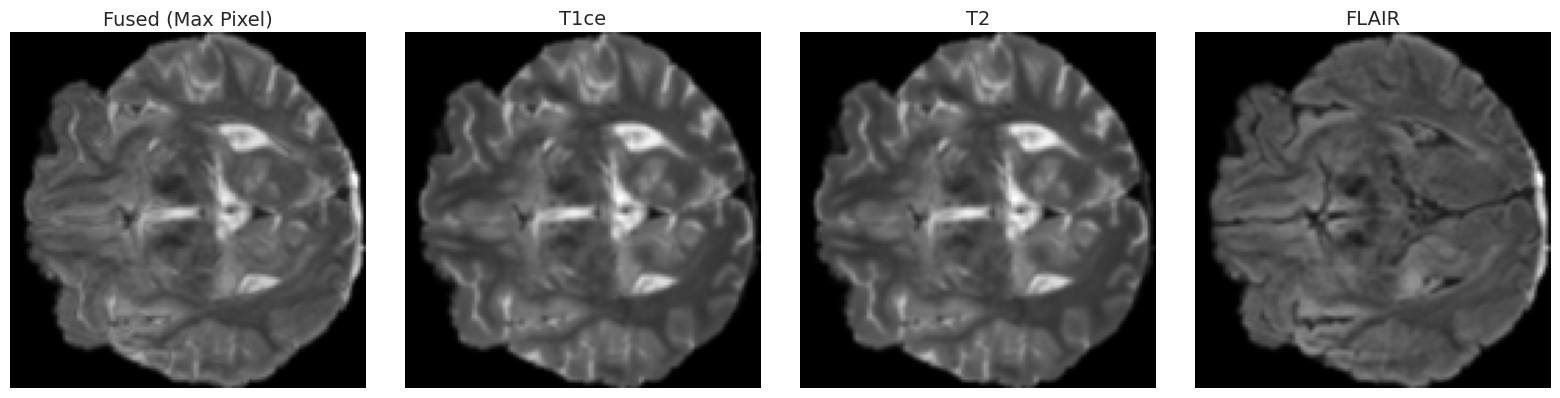

In [12]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import pandas as pd
from skimage.metrics import structural_similarity, peak_signal_noise_ratio, mean_squared_error
from skimage.measure import shannon_entropy
from scipy.ndimage import gaussian_filter
import logging

# ---------- Logging Setup ----------
logging.basicConfig(filename='/kaggle/working/fusion_metrics.log', level=logging.INFO, 
                    format='%(asctime)s - %(message)s')

# ---------- Helper Functions ----------
def normalize_image(img):
    img = np.nan_to_num(img, nan=0, posinf=0, neginf=0)
    if img.max() == img.min():
        return np.zeros_like(img)
    return (img - img.min()) / (img.max() - img.min())

# ---------- Settings ----------
input_dir = "/kaggle/working/processed"
output_dir = "/kaggle/working/fused_spatial"
os.makedirs(output_dir, exist_ok=True)

max_patients = 150
slice_range = range(30, 111)
metrics = {'T1ce': [], 'T2': [], 'FLAIR': []}
# ---------- Processing ----------
patient_dirs = os.listdir(input_dir)
last_fused = last_modalities = None
for i, patient_id in enumerate(patient_dirs):
    if i >= max_patients:
        break

    patient_path = os.path.join(input_dir, patient_id)
    flair_path = os.path.join(patient_path, "flair.nii.gz")
    t1ce_path = os.path.join(patient_path, "t1ce.nii.gz")
    t2_path = os.path.join(patient_path, "t2.nii.gz")

    if not all(os.path.exists(p) for p in [flair_path, t1ce_path, t2_path]):
        continue

    try:
        flair = nib.load(flair_path).get_fdata()
        t1ce = nib.load(t1ce_path).get_fdata()
        t2 = nib.load(t2_path).get_fdata()
    except:
        continue

    # Filter
    flair = gaussian_filter(flair, sigma=0.5)
    t1ce = gaussian_filter(t1ce, sigma=0.5)
    t2 = gaussian_filter(t2, sigma=0.5)

    # Normalize
    flair_norm = normalize_image(flair)
    t1ce_norm = normalize_image(t1ce)
    t2_norm = normalize_image(t2)

    # ---------- Fusion using Max Pixel ----------
    stacked = np.stack([flair_norm, t1ce_norm, t2_norm], axis=0)
    fused_max = np.max(stacked, axis=0)
    fused_max = np.clip(fused_max, 0, 1)

    # Save NIfTI
    nib.save(nib.Nifti1Image(fused_max, affine=np.eye(4)), 
             os.path.join(output_dir, f"{patient_id}_fused.nii.gz"))

    # ---------- Step 3: Evaluate Metrics ----------
    modalities = {'T1ce': t1ce, 'T2': t2, 'FLAIR': flair}
    for name, img in modalities.items():
        slices_available = min(img.shape[2], fused_max.shape[2], 80)
        ssim_vals = [structural_similarity(fused_max[:, :, i], img[:, :, i], data_range=1.0) for i in range(slices_available)]
        entropy_vals = [shannon_entropy(fused_max[:, :, i]) for i in range(slices_available)]

        mse = mean_squared_error(fused_max, img)
        psnr = peak_signal_noise_ratio(fused_max, img, data_range=1.0)
        ssim = np.mean(ssim_vals)
        entropy = np.mean(entropy_vals)

        metrics[name].append({
            'Patient': patient_id,
            'MSE': mse,
            'PSNR': psnr,
            'SSIM': ssim,
            'Entropy': entropy
        })

    # Store last patient images for visualization
    last_fused = fused_max
    last_modalities = {'T1ce': t1ce, 'T2': t2, 'FLAIR': flair}

# ---------- Step 4: Save Metrics to CSV ----------
for name in metrics:
    df = pd.DataFrame(metrics[name])
    df.to_csv(f'metrics_{name}.csv', index=False)

    # Print average metrics
    mse_avg = np.mean([m['MSE'] for m in metrics[name]])
    psnr_avg = np.mean([m['PSNR'] for m in metrics[name]])
    ssim_avg = np.mean([m['SSIM'] for m in metrics[name]])
    entropy_avg = np.mean([m['Entropy'] for m in metrics[name]])

    print(f"Comparison with {name} (average over {len(metrics[name])} patients)")
    print(f"  - MSE     : {mse_avg:.6f}")
    print(f"  - PSNR    : {psnr_avg:.4f} dB")
    print(f"  - SSIM    : {ssim_avg:.4f}")
    print(f"  - Entropy : {entropy_avg:.4f}")
    print("--------------------------")

# ---------- Step 5: Visual Sample (last patient) ----------
if last_fused is not None and last_modalities is not None:
    slice_idx = 40
    plt.figure(figsize=(16, 4))
    plt.subplot(1, 4, 1); plt.imshow(last_fused[:, :, slice_idx], cmap='gray'); plt.title("Fused (Max Pixel)"); plt.axis('off')
    plt.subplot(1, 4, 2); plt.imshow(last_modalities['T1ce'][:, :, slice_idx], cmap='gray'); plt.title("T1ce"); plt.axis('off')
    plt.subplot(1, 4, 3); plt.imshow(last_modalities['T2'][:, :, slice_idx], cmap='gray'); plt.title("T2"); plt.axis('off')
    plt.subplot(1, 4, 4); plt.imshow(last_modalities['FLAIR'][:, :, slice_idx], cmap='gray'); plt.title("FLAIR"); plt.axis('off')
    plt.tight_layout()
    plt.show()


/tmp/ipykernel_35/377377316.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


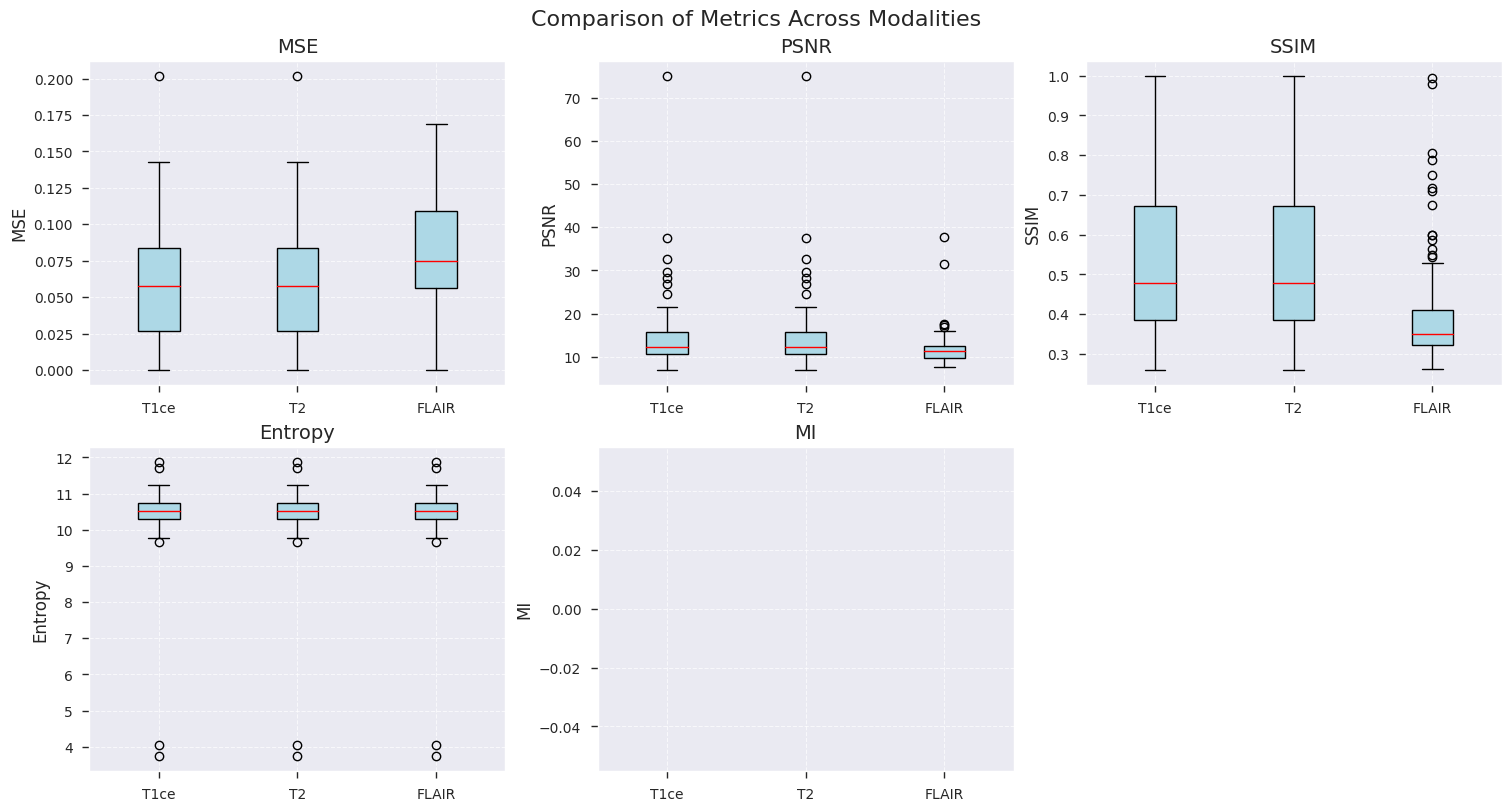

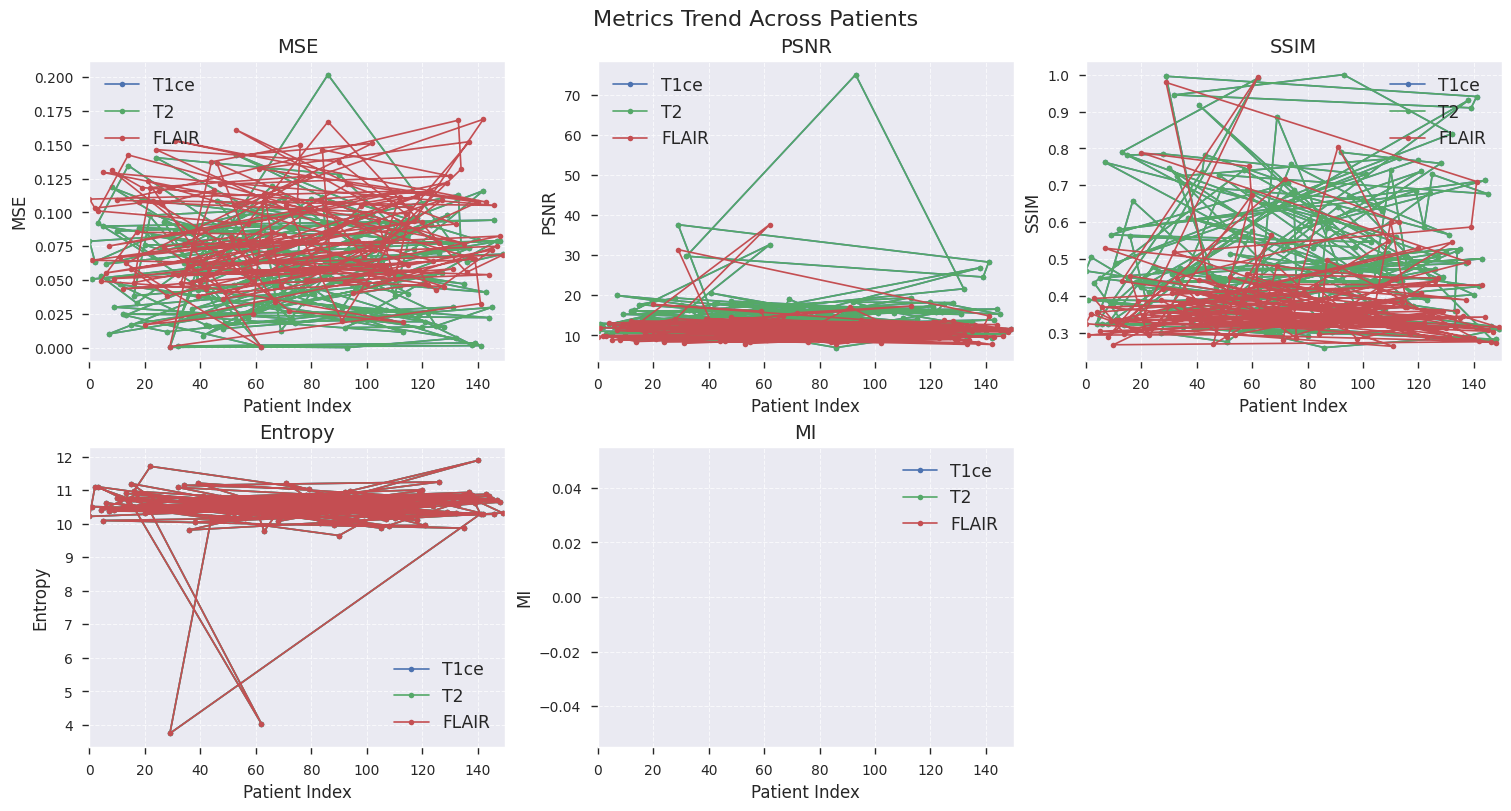

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nibabel as nib
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio, structural_similarity
from skimage.measure import shannon_entropy
from scipy.stats import entropy as scipy_entropy
import os

# Set plotting style for research paper
plt.style.use('seaborn')
sns.set_context("paper", font_scale=1.4)
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

# Paths
output_path = '/kaggle/working'
metrics_files = {
    'T1ce': 'metrics_T1ce.csv',
    'T2': 'metrics_T2.csv',
    'FLAIR': 'metrics_FLAIR.csv'
}

# Function to calculate Mutual Information
def mutual_information(img1, img2, bins=256):
    # Flatten images
    img1_flat = img1.flatten()
    img2_flat = img2.flatten()
    
    # Compute histograms
    hist_2d, x_edges, y_edges = np.histogram2d(img1_flat, img2_flat, bins=bins)
    hist_2d = hist_2d / np.sum(hist_2d)  # Normalize to get joint probability
    hist_1 = np.sum(hist_2d, axis=1)
    hist_2 = np.sum(hist_2d, axis=0)
    
    # Compute entropies
    mi = 0
    for i in range(bins):
        for j in range(bins):
            if hist_2d[i, j] > 0:
                mi += hist_2d[i, j] * np.log2(hist_2d[i, j] / (hist_1[i] * hist_2[j]))
    return mi

# Load metrics and add MI if not present
metrics_data = {}
for modality, file in metrics_files.items():
    file_path = os.path.join(output_path, file)
    if not os.path.exists(file_path):
        print(f"Metrics file not found: {file_path}")
        continue
    
    df = pd.read_csv(file_path)
    
    # If MI is not in the dataframe, calculate it (assuming images are available)
    if 'MI' not in df.columns:
        mi_values = []
        for idx, row in df.iterrows():
            patient = row['Patient']
            patient_path = os.path.join('/kaggle/working/processed', patient)
            fused_path = os.path.join(patient_path, 'fused_final_3d.nii.gz')
            modality_path = os.path.join(patient_path, f'{modality.lower()}.nii.gz')
            
            try:
                fused_img = nib.load(fused_path).get_fdata()[:, :, 30:min(110, int(row['Num_Slices']))]
                modality_img = nib.load(modality_path).get_fdata()[:, :, 30:min(110, int(row['Num_Slices']))]
                mi = mutual_information(fused_img, modality_img)
                mi_values.append(mi)
            except:
                mi_values.append(np.nan)  # In case of error, append NaN
        df['MI'] = mi_values
    
    metrics_data[modality] = df

# Metrics to plot
metrics_to_plot = ['MSE', 'PSNR', 'SSIM', 'Entropy', 'MI']

# Create Boxplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8), constrained_layout=True)
axes = axes.flatten()

for idx, metric in enumerate(metrics_to_plot):
    data = []
    labels = []
    for modality in metrics_data:
        values = metrics_data[modality][metric].dropna()
        data.append(values)
        labels.append(modality)
    
    axes[idx].boxplot(data, labels=labels, patch_artist=True, 
                     boxprops=dict(facecolor='lightblue', color='black'),
                     whiskerprops=dict(color='black'),
                     capprops=dict(color='black'),
                     medianprops=dict(color='red'))
    axes[idx].set_title(metric)
    axes[idx].set_ylabel(metric)
    axes[idx].grid(True, linestyle='--', alpha=0.7)

# Remove empty subplot if any
for idx in range(len(metrics_to_plot), len(axes)):
    fig.delaxes(axes[idx])

plt.suptitle('Comparison of Metrics Across Modalities', fontsize=16)
plt.savefig(os.path.join(output_path, 'boxplots_metrics.png'), dpi=300, bbox_inches='tight')
plt.show()

# Create Line Plots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8), constrained_layout=True)
axes = axes.flatten()

for idx, metric in enumerate(metrics_to_plot):
    for modality in metrics_data:
        df = metrics_data[modality].sort_values('Patient')
        values = df[metric].dropna()
        axes[idx].plot(df.index[:len(values)], values, label=modality, marker='o', markersize=4)
    
    axes[idx].set_title(metric)
    axes[idx].set_xlabel('Patient Index')
    axes[idx].set_ylabel(metric)
    axes[idx].set_xlim(0, len(df))
    axes[idx].legend()
    axes[idx].grid(True, linestyle='--', alpha=0.7)

# Remove empty subplot if any
for idx in range(len(metrics_to_plot), len(axes)):
    fig.delaxes(axes[idx])

plt.suptitle('Metrics Trend Across Patients', fontsize=16)
plt.savefig(os.path.join(output_path, 'lineplots_metrics.png'), dpi=300, bbox_inches='tight')
plt.show()